In [1]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df_res = pd.read_pickle('COSMOS2020-with-FORS2-HSC_only-jaxcosmo_results.pkl')

In [3]:
df_res

,Mag(cosmos_u_cfht),MagErr(cosmos_u_cfht),Mag(cosmos_u_new),MagErr(cosmos_u_new),Mag(hsc_gHSC),MagErr(hsc_gHSC),Mag(hsc_rHSC),MagErr(hsc_rHSC),Mag(hsc_iHSC),MagErr(hsc_iHSC),Mag(hsc_zHSC),MagErr(hsc_zHSC),Mag(hsc_yHSC),MagErr(hsc_yHSC),Photometric redshift,True redshift,Template SED,Extinction law,E(B-V),Chi2
697.0,23.352457,0.006560,23.336033,0.009069,23.191482,0.011916,22.914457,0.010221,22.474033,0.007509,22.222769,0.008010,22.049270,0.009592,0.71,1.028000,CWW_Im-id699,Calzetti,0.2,1705.105748
10380.0,24.527059,0.014841,24.601852,0.025738,23.780503,0.015930,22.828888,0.009744,22.226021,0.006567,21.999968,0.007017,21.842446,0.008098,2.81,0.600500,CWW_Im-id699,Prevot,0.1,6393.195871
4977.0,24.079610,0.014593,24.181521,0.025347,22.524837,0.010185,20.936210,0.004632,20.149380,0.002871,19.791285,0.002827,19.583927,0.002928,2.91,0.471000,CWW_Im-id699,Prevot,0.1,60097.977679
18353.0,20.362197,0.001399,20.384480,0.001266,19.339057,0.002559,18.578011,0.001737,18.147359,0.001270,17.928892,0.001329,17.770970,0.001387,2.31,0.193000,CWW_Im-id344,Calzetti,0.1,250461.285714
12733.0,23.979550,0.009967,24.038714,0.016058,23.110693,0.011899,22.053003,0.006916,21.601261,0.005027,21.248349,0.004996,21.153274,0.005767,2.71,0.372200,CWW_Im-id699,Prevot,0.1,14030.977679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6016.0,24.720967,0.017160,24.664213,0.030247,24.422806,0.020954,24.337655,0.020411,24.229073,0.018701,23.732866,0.017988,23.591035,0.025923,1.71,1.361000,CWW_Im-id344,Calzetti,0.2,151.706124
1652.0,25.023257,0.037878,25.112938,0.044767,23.032706,0.013666,21.336915,0.005770,20.162967,0.002974,19.742003,0.002841,19.485542,0.002899,3.01,0.673200,CWW_Im-id699,Prevot,0.1,59299.008929
16434.0,25.711148,0.046798,25.697210,0.060749,24.317222,0.022211,22.742698,0.009659,21.540787,0.004856,21.095776,0.004608,20.794856,0.004721,0.31,0.666700,CWW_Im-id699,Prevot,0.4,20282.013393
4274.0,26.688140,0.121102,26.509103,0.125498,26.084211,0.066966,25.499202,0.046693,24.776123,0.029375,24.099307,0.025547,23.403041,0.024319,0.51,1.461251,AVG_CLUST_CWW_Im,Prevot,0.1,352.072475


(0.0, 3.0)

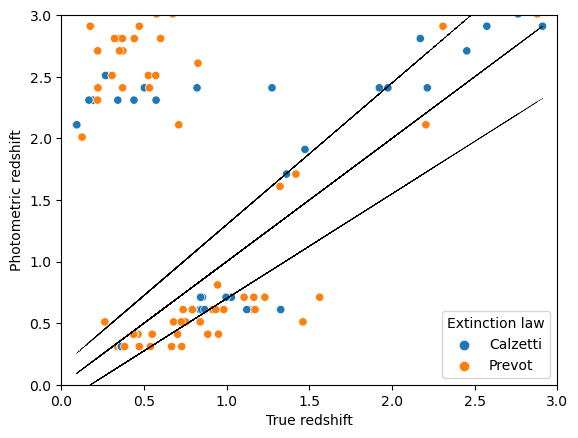

In [4]:
f,a = plt.subplots(1,1)
sns.scatterplot(data=df_res, x='True redshift', y='Photometric redshift', hue='Extinction law', ax=a)
a.plot(df_res['True redshift'], df_res['True redshift'], c='k', lw=0.5)
a.plot(df_res['True redshift'], 0.15+1.15*df_res['True redshift'], c='k', ls=':', lw=0.5)
a.plot(df_res['True redshift'], -0.15+0.85*df_res['True redshift'], c='k', ls=':', lw=0.5)
a.set_xlim(0.,3.0)
a.set_ylim(0.,3.0)

In [5]:
with open('COSMOS2020-with-FORS2-HSC_only-jaxcosmo_results_dicts.pkl', 'rb') as handle:
    results_dict=pickle.load(handle)

In [6]:
keys = [key for key in results_dict.keys()]
_ex_=keys[0]
zps=np.array(sorted(np.unique(results_dict[_ex_]['zp'])))
zps

array([0.01, 0.11, 0.21, 0.31, 0.41, 0.51, 0.61, 0.71, 0.81, 0.91, 1.01,
       1.11, 1.21, 1.31, 1.41, 1.51, 1.61, 1.71, 1.81, 1.91, 2.01, 2.11,
       2.21, 2.31, 2.41, 2.51, 2.61, 2.71, 2.81, 2.91, 3.01])

In [7]:
key_0=_ex_
dict_0=results_dict[key_0]
dict_0

{'zp': [0.01,
  0.11,
  0.21000000000000002,
  0.31000000000000005,
  0.41000000000000003,
  0.51,
  0.6100000000000001,
  0.7100000000000001,
  0.81,
  0.91,
  1.01,
  1.11,
  1.2100000000000002,
  1.31,
  1.4100000000000001,
  1.51,
  1.61,
  1.7100000000000002,
  1.81,
  1.9100000000000001,
  2.01,
  2.11,
  2.21,
  2.31,
  2.41,
  2.51,
  2.61,
  2.71,
  2.81,
  2.91,
  3.01,
  0.01,
  0.11,
  0.21000000000000002,
  0.31000000000000005,
  0.41000000000000003,
  0.51,
  0.6100000000000001,
  0.7100000000000001,
  0.81,
  0.91,
  1.01,
  1.11,
  1.2100000000000002,
  1.31,
  1.4100000000000001,
  1.51,
  1.61,
  1.7100000000000002,
  1.81,
  1.9100000000000001,
  2.01,
  2.11,
  2.21,
  2.31,
  2.41,
  2.51,
  2.61,
  2.71,
  2.81,
  2.91,
  3.01,
  0.01,
  0.11,
  0.21000000000000002,
  0.31000000000000005,
  0.41000000000000003,
  0.51,
  0.6100000000000001,
  0.7100000000000001,
  0.81,
  0.91,
  1.01,
  1.11,
  1.2100000000000002,
  1.31,
  1.4100000000000001,
  1.51,
  1.61,
  1

In [8]:
df0 = pd.DataFrame(dict_0)
df0

,zp,chi2,mod id,ext law,eBV
0,0.01,5315.878348,AVG_CLUST_CWW_Sbc,Calzetti,0.0
1,0.11,5841.821429,AVG_CLUST_CWW_Sbc,Calzetti,0.0
2,0.21,6143.148438,AVG_CLUST_CWW_Sbc,Calzetti,0.0
3,0.31,6329.596540,AVG_CLUST_CWW_Sbc,Calzetti,0.0
4,0.41,6405.202567,AVG_CLUST_CWW_Sbc,Calzetti,0.0
...,...,...,...,...,...
4459,2.61,13608.796875,KIN_Sa-id674,Prevot,0.4
4460,2.71,13456.690848,KIN_Sa-id674,Prevot,0.4
4461,2.81,13239.168527,KIN_Sa-id674,Prevot,0.4
4462,2.91,12967.844866,KIN_Sa-id674,Prevot,0.4


<AxesSubplot: xlabel='zp', ylabel='chi2'>

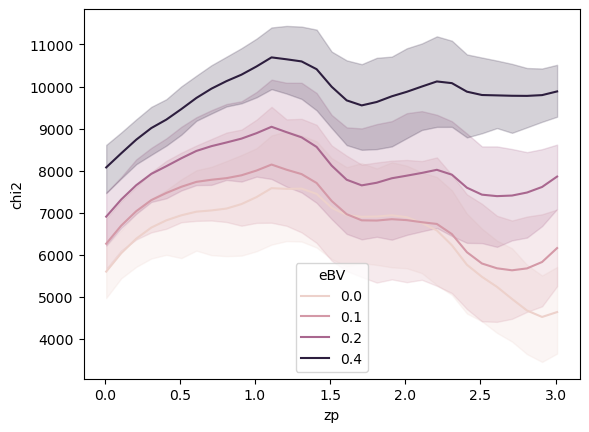

In [9]:
sns.lineplot(data=df0, x='zp', y='chi2', hue='eBV')

In [10]:
_sel = (df0['eBV']==0.0) * (df0['ext law']=='Calzetti')
df00 = df0[_sel]
df000 = df00[df00['chi2']<1000000]

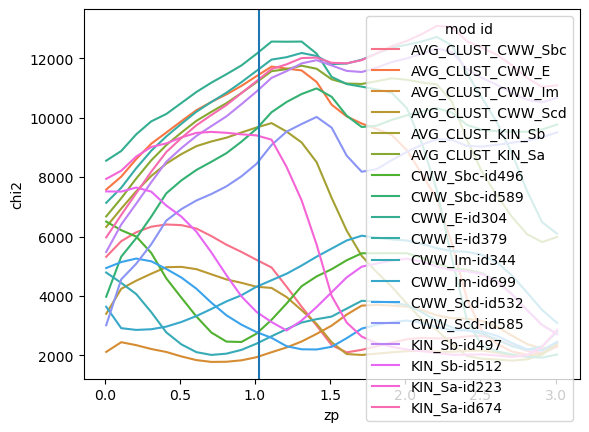

In [11]:
f,a = plt.subplots(1,1)
sns.lineplot(data=df000, x='zp', y='chi2', hue='mod id', ax=a)
a.axvline(df_res.loc[key_0, 'True redshift'])

In [12]:
chi_arr_mod = np.column_stack([df00[df00['mod id']==mod]['chi2'].values for mod in np.unique(df00['mod id'].values)]) # if 'CWW' in mod])

In [13]:
chi_arr_mod.shape

(31, 18)

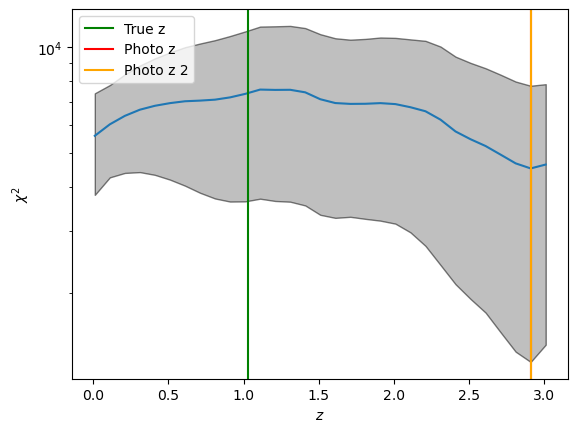

In [14]:
f,a = plt.subplots(1,1)
chi_avg = np.average(chi_arr_mod, axis=1)
chi_std = np.std(chi_arr_mod, axis=1)
a.semilogy(zps, chi_avg)
a.fill_between(x=zps, y1=chi_avg-chi_std, y2=chi_avg+chi_std, alpha=0.5, facecolor='grey', edgecolor='k')
a.axvline(df_res.loc[key_0, 'True redshift'], label='True z', c='g')
a.axvline(zps[np.nanargmin(chi_avg)], label='Photo z', c='r')
a.axvline(zps[np.nanargmin(chi_avg-chi_std)], label='Photo z 2', c='orange')
a.set_xlabel('$z$')
a.set_ylabel('$\chi^2$')
a.legend()

OK donc c'est pas complètement sans espoir ! Il faudrait intégrer la visualisation de ces résultats dans un dash maintenant...

In [22]:
df_temp_prop = pd.read_pickle('COSMOS2020-with-FORS2-HSC_only-jaxcosmo_templates_properties.pkl')

In [23]:
df_temp_prop

,Model,Path,Redshift,Extinction law,E(B-V),Cosmology,Luminosity distance,Lookback time,Mag(cosmos_u_cfht),Mag(cosmos_u_new),Mag(hsc_gHSC),Mag(hsc_rHSC),Mag(hsc_iHSC),Mag(hsc_zHSC),Mag(hsc_yHSC)
0,AVG_CLUST_CWW_Sbc,/home/joseph/PhotoZ_PhD/LEPHARE/sed/GAL/FORS2_...,0.01,Calzetti,0.0,LCDM_h0=70.0-Om0=0.3-l0=0.7,[21.424377],13332376000.0,[14.546911],[14.775703],[13.739801],[13.25466],[12.910938],[12.735973],[12.565519]
1,AVG_CLUST_CWW_Sbc,/home/joseph/PhotoZ_PhD/LEPHARE/sed/GAL/FORS2_...,0.11,Calzetti,0.0,LCDM_h0=70.0-Om0=0.3-l0=0.7,[249.76756],12049095000.0,[20.06008],[20.165771],[19.115107],[18.546793],[18.191788],[17.95851],[17.859648]
2,AVG_CLUST_CWW_Sbc,/home/joseph/PhotoZ_PhD/LEPHARE/sed/GAL/FORS2_...,0.21,Calzetti,0.0,LCDM_h0=70.0-Om0=0.3-l0=0.7,[506.63922],10933600000.0,[21.58094],[21.670876],[20.786674],[20.051996],[19.678257],[19.437195],[19.29776]
3,AVG_CLUST_CWW_Sbc,/home/joseph/PhotoZ_PhD/LEPHARE/sed/GAL/FORS2_...,0.31,Calzetti,0.0,LCDM_h0=70.0-Om0=0.3-l0=0.7,[788.915],9960156000.0,[22.513744],[22.586346],[21.902603],[21.015545],[20.591343],[20.372568],[20.199337]
4,AVG_CLUST_CWW_Sbc,/home/joseph/PhotoZ_PhD/LEPHARE/sed/GAL/FORS2_...,0.41,Calzetti,0.0,LCDM_h0=70.0-Om0=0.3-l0=0.7,[1093.7996],9107570000.0,[23.180088],[23.220491],[22.7573],[21.743902],[21.281313],[21.026636],[20.893007]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4459,KIN_Sa-id674,/home/joseph/PhotoZ_PhD/LEPHARE/sed/GAL/FORS2_...,2.61,Prevot,0.4,LCDM_h0=70.0-Om0=0.3-l0=0.7,[10456.456],2459473700.0,[38.57611],[39.02645],[36.46401],[33.903625],[30.942822],[30.028236],[28.598442]
4460,KIN_Sa-id674,/home/joseph/PhotoZ_PhD/LEPHARE/sed/GAL/FORS2_...,2.71,Prevot,0.4,LCDM_h0=70.0-Om0=0.3-l0=0.7,[10942.185],2362190600.0,[38.85783],[39.33964],[36.74546],[34.292007],[31.24318],[30.287823],[28.9897]
4461,KIN_Sa-id674,/home/joseph/PhotoZ_PhD/LEPHARE/sed/GAL/FORS2_...,2.81,Prevot,0.4,LCDM_h0=70.0-Om0=0.3-l0=0.7,[11430.831],2271088600.0,[39.15415],[39.712185],[37.02934],[34.671776],[31.606571],[30.494442],[29.414782]
4462,KIN_Sa-id674,/home/joseph/PhotoZ_PhD/LEPHARE/sed/GAL/FORS2_...,2.91,Prevot,0.4,LCDM_h0=70.0-Om0=0.3-l0=0.7,[11922.248],2185638000.0,[39.47909],[40.013103],[37.28642],[35.0794],[32.028255],[30.591991],[29.838284]


In [17]:
np.power(10., -0.4*(df_temp_prop.loc[0,'Mag(cosmos_u_new)'] +48.6)

1.1000347805325187e-26